In [1]:
from stage1 import *

In [2]:
nframes,natoms,nmols=(0,0,0)

In [3]:
from stage2 import * 

In [4]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [5]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [6]:
cf=condenseframe(testframe)

In [7]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [8]:
cf

array([[ 7.84576243e+02, -9.36140506e+01, -1.56635818e+02,
         2.28225017e+00,  9.52250063e-01,  1.95350003e+00],
       [ 7.79803099e+02, -9.30955292e+01, -1.55628271e+02,
         1.36549997e+00,  1.45650005e+00,  2.59900022e+00],
       [ 8.75985383e+02, -1.05724399e+02, -1.74737958e+02,
         8.33750010e-01,  1.77175009e+00,  7.37500072e-01],
       ...,
       [ 7.41200941e+02, -8.83453476e+01, -1.47991849e+02,
         2.56474996e+00,  1.57500005e+00,  2.47574997e+00],
       [ 7.57661722e+02, -9.03470056e+01, -1.51268077e+02,
         1.61825013e+00,  1.92200017e+00,  2.49900007e+00],
       [ 8.03441321e+02, -9.64539095e+01, -1.60332419e+02,
         7.91500092e-01,  2.24175000e+00,  2.16525006e+00]])

In [9]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:02<00:00, 20.96it/s]

30192


In [10]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [11]:
g = get_graph(cf,1,n_neigh,"cry")

In [12]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [13]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 20
batch_size=16
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [14]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:02<00:00, 11905.68it/s]


In [15]:
graphs = graphs_device
total_graphs = len(graphs)


In [16]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 16
number of batches: 1887
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [17]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [18]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        loss = MSE_loss(decoded_x, data.x)
        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [19]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [20]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 3249.7471
	Test: 	MSE Loss: 2919.1839
Epoch: 002
	Train:	MSE Loss: 2305.2309
	Test: 	MSE Loss: 1832.4315
Epoch: 003
	Train:	MSE Loss: 1573.6175
	Test: 	MSE Loss: 1120.9400
Epoch: 004
	Train:	MSE Loss: 1215.4777
	Test: 	MSE Loss: 982.6848
Epoch: 005
	Train:	MSE Loss: 1054.7054
	Test: 	MSE Loss: 885.7514
Epoch: 006
	Train:	MSE Loss: 950.3852
	Test: 	MSE Loss: 825.2334
Epoch: 007
	Train:	MSE Loss: 880.7331
	Test: 	MSE Loss: 787.8099
Epoch: 008
	Train:	MSE Loss: 840.8129
	Test: 	MSE Loss: 811.1518
Epoch: 009
	Train:	MSE Loss: 808.4546
	Test: 	MSE Loss: 742.7278
Epoch: 010
	Train:	MSE Loss: 782.2871
	Test: 	MSE Loss: 724.4888
Epoch: 011
	Train:	MSE Loss: 767.0246
	Test: 	MSE Loss: 699.8536
Epoch: 012
	Train:	MSE Loss: 754.0151
	Test: 	MSE Loss: 744.7557
Epoch: 013
	Train:	MSE Loss: 747.9663
	Test: 	MSE Loss: 684.8871
Epoch: 014
	Train:	MSE Loss: 741.9440
	Test: 	MSE Loss: 685.5781
Epoch: 015
	Train:	MSE Loss: 739.4244
	Test: 	MSE Loss: 723.5756
Epoch: 016
	Train

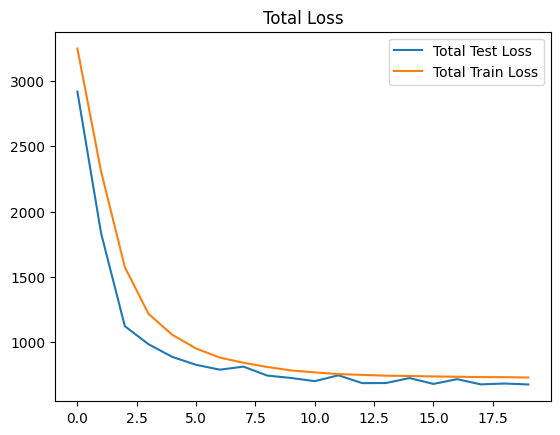

In [21]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

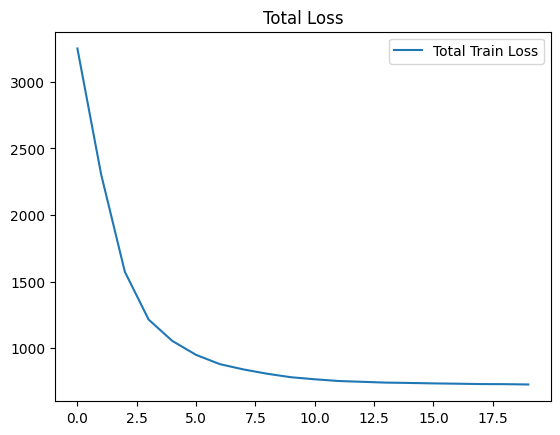

In [22]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

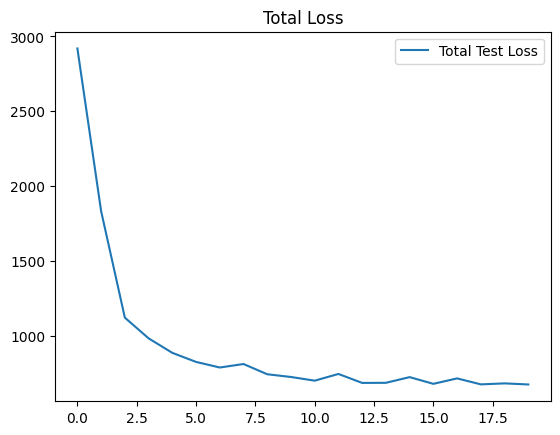

In [23]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [24]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


Average Error 707.7590988781893


In [25]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[0][heavy_indices])

21

In [26]:
decoded_feature[0][heavy_indices]

tensor([[-1.0996e+00, -1.4346e-02, -9.5115e-03,  1.9403e+01,  1.9623e+01,
          1.8189e+01],
        [-5.3173e-01, -1.1074e-01, -4.1783e-01,  1.8186e+01,  1.8199e+01,
          1.7666e+01],
        [-4.9393e-01, -1.5334e-01, -5.2783e-01,  1.8052e+01,  1.8051e+01,
          1.7485e+01],
        [-5.4280e-01, -9.9582e-02, -3.8844e-01,  1.8200e+01,  1.8227e+01,
          1.7681e+01],
        [-5.4233e-01, -1.0006e-01, -3.8969e-01,  1.8199e+01,  1.8226e+01,
          1.7681e+01],
        [-5.2943e-01, -1.1305e-01, -4.2394e-01,  1.8184e+01,  1.8193e+01,
          1.7662e+01],
        [-5.1580e-01, -1.2667e-01, -4.5996e-01,  1.8160e+01,  1.8152e+01,
          1.7636e+01],
        [-4.7491e-01, -1.8581e-01, -6.0625e-01,  1.7833e+01,  1.7905e+01,
          1.7153e+01],
        [-5.2151e-01, -1.2097e-01, -4.4486e-01,  1.8170e+01,  1.8170e+01,
          1.7647e+01],
        [-4.8452e-01, -1.6934e-01, -5.6645e-01,  1.7944e+01,  1.7979e+01,
          1.7322e+01],
        [-5.2491e-01, -1.1757e

In [27]:
input_feature[0][heavy_indices]

tensor([[-9.7072e+00, -9.7939e-02, -2.7271e-01,  1.9093e+01,  2.1693e+01,
          2.2518e+01],
        [-1.0301e+01, -1.6178e-01, -2.6869e-01,  2.0650e+01,  2.0815e+01,
          2.4435e+01],
        [-8.8493e+00,  4.4686e-03, -2.6268e-01,  1.6808e+01,  2.2738e+01,
          2.1628e+01],
        [-9.3875e+00, -5.9207e-02, -2.6549e-01,  1.6928e+01,  2.1688e+01,
          2.4298e+01],
        [-8.3796e+00,  5.4994e-02, -2.6768e-01,  1.9908e+01,  1.9470e+01,
          2.0413e+01],
        [-9.2884e+00, -4.9337e-02, -2.6915e-01,  1.9993e+01,  2.2483e+01,
          1.9210e+01],
        [-1.0712e+01, -2.0816e-01, -2.7008e-01,  2.0158e+01,  2.4885e+01,
          2.1018e+01],
        [-1.1659e+01, -3.1172e-01, -2.5948e-01,  2.1685e+01,  2.4065e+01,
          2.4125e+01],
        [-8.7857e+00,  1.1287e-02, -2.6452e-01,  2.1490e+01,  1.8170e+01,
          2.2090e+01],
        [-1.0419e+01, -1.7209e-01, -2.6409e-01,  1.7382e+01,  2.5853e+01,
          2.2355e+01],
        [-7.3490e+00,  1.6923e

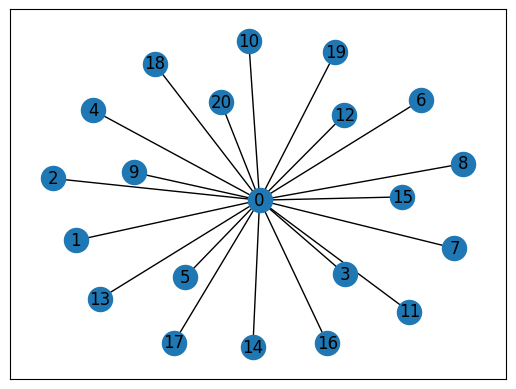

In [28]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()
